# Imports

In [23]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import glob
from geocat.viz import util as gvutil
import csv

# Useful Functions

In [14]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


def index_plot(ds1, name1='', threshold=0.5):
    lim = 6 * threshold
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(ds1.time, ds1, color='black', label=name1)
    gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)
    
    gvutil.set_axes_limits_and_ticks(ax, ylim=(-1*lim, lim))
    ax.fill_between(ds1.time, ds1, y2=-threshold,
                    where=ds1 < -threshold, color='blue', interpolate=True)
    ax.fill_between(ds1.time, ds1, y2=threshold,
                    where=ds1> threshold, color='red', interpolate=True)
    plt.title(f'{name1}')
    ax.set_xlabel('year', fontsize=24)
    plt.grid()
    plt.show()

# PBSClustter

In [3]:
# Create a PBS cluster object
cluster = PBSCluster(account='P93300313',
                     job_name='ATLN-ENSO-CESMLE2',
                     cores=1,
                     memory='8GiB',
                     processes=1,
                     walltime='02:00:00',
                     queue='casper',
                     interface='ext',
                     n_workers=1)

# dont scale many workers unless using LE
# cluster.scale(10)

client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44193 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/44193/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/44193/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.179:45347,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/44193/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.scale(2)

In [34]:
client.shutdown()
# cluster.workers

# Import

In [6]:
# start with hadisst files
ds = xr.open_dataset('/glade/campaign/collections/rda/data/d277003/HadISST_sst.nc.gz').compute()
ds

<xarray.Dataset> Size: 482MB
Dimensions:    (time: 1861, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB 0.0 31.0 31.0 ... 5.661e+04 5.664e+04
    sst        (time, latitude, longitude) float32 482MB -1e+03 -1e+03 ... nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    3/3/2025 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

# select

In [7]:
dates = xr.date_range(start='1920-01-16', end='2025-01-16', freq='1ME')
ds = ds.sel(time=dates, method='nearest')
ENSO34_hadisst = ds['sst'].sel(latitude=slice(5, -5), longitude=slice(-170, -120)).compute()

# ONI Index

In [8]:
# get weighted latitudes
weights = np.cos(np.deg2rad(ENSO34_hadisst.latitude))
weights.name = "weights"

In [9]:
ENSO34_clim = ENSO34_hadisst.groupby(ENSO34_hadisst['time'].dt.month).mean(dim='time').compute()
ENSO34_anom = ENSO34_hadisst.groupby(ENSO34_hadisst['time'].dt.month) - ENSO34_clim
# all anomaly fields were linearly detrended zhang et al
ENSO34_anom_dtrend = detrend_dim(ENSO34_anom, dim='time')

In [19]:
ENSO34_roll = ENSO34_anom_dtrend.rolling(time=3, center=True).mean()
ONI = ENSO34_roll.mean(('longitude', 'latitude'), skipna=True).compute()

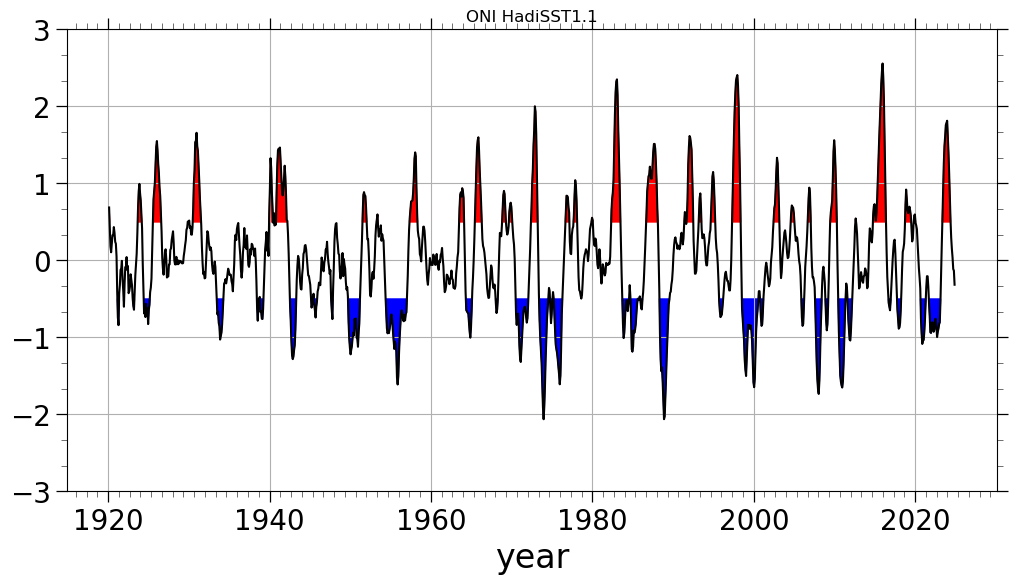

In [20]:
index_plot(ONI, name1='ONI HadiSST1.1')

In [21]:
ONI_s = ONI.where(ENSO34_roll['time.season'] == 'JJA')

ONI_p = np.unique(ONI_s.where(ONI_s >= 0.5, drop=True).time.dt.year)
ONI_n = np.unique(ONI_s.where(ONI_s <= -0.5, drop=True).time.dt.year)

print(('Niño', ONI_p))
print(('Niña', ONI_n))

('Niño', array([1925, 1926, 1930, 1931, 1940, 1941, 1951, 1957, 1963, 1965, 1972,
       1982, 1983, 1987, 1991, 1992, 1993, 1997, 2002, 2004, 2009, 2012,
       2015, 2019, 2023]))
('Niña', array([1924, 1933, 1938, 1942, 1945, 1950, 1954, 1955, 1956, 1964, 1970,
       1971, 1973, 1974, 1975, 1984, 1985, 1988, 1989, 1998, 1999, 2000,
       2007, 2010, 2011, 2022]))


In [22]:
print(('intersection', set(ONI_p) & set(ONI_n)))

('intersection', set())


# Export

In [28]:
max_len = max(len(ONI_p), len(ONI_n))


a = [str(item) for item in ONI_p]
b = [str(item) for item in ONI_n]
# Pad shorter lists with empty strings
a_padded = a + [''] * (max_len - len(a))
b_padded = b + [''] * (max_len - len(b))

# Export to CSV
with open('Results/ONI_years.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Niño', 'Niña'])  # header
    for i in range(max_len):
        writer.writerow([a_padded[i], b_padded[i]])

In [33]:
ONI_ds = ONI.to_dataset(name='ONI')
ONI_ds.to_netcdf('Results/ONI.nc')
ONI_ds

<xarray.Dataset> Size: 30kB
Dimensions:  (time: 1260)
Coordinates:
  * time     (time) datetime64[ns] 10kB 1920-01-16T12:00:00 ... 2024-12-16T12...
    month    (time) int64 10kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    ONI      (time) float64 10kB nan 0.688 0.4189 0.1816 ... -0.1326 -0.315 nan